# NGFS Clean & Interp

### 01/29/24, Erica Simon
## Purpose: prepare IAM projections of future emissions under different policy scenarios
- Appropriate for harmonization
- Interpolated to annual intervals (rather than 5 year timesteps)
- Containing all necessary forcing agents required by FaIR


Data Credit: 
- Richters, O. *et al.* (2023). *NGFS Climate Scenarios Data Set* (4.1). Zenodo. https://doi.org/10.5281/ZENODO.10079020





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Helper Functions
Interpolate function defined here so it can be used to interpolate datasets before they are infilled with missing species. These non-infilled datasets will be used as input into Silicone to test another method of infilling

In [2]:
def NGFS_interp(df, yrs, all_yrs):
    
    # create empty df
    df_interp = pd.DataFrame()
    df_interp[['Model', 'Scenario', 'Region', 'Variable', 'Unit']] = np.nan
    df_interp[all_yrs] = np.nan
    
    mdl = df.Model.values[0]
    reg = df.Region.values[0]
    
    # interpolate and add all values in timeseries
    for scen in df.Scenario.unique():
        for var in df.Variable.unique():
            proj = df.loc[df.Variable == var].loc[df.Scenario == scen]
            proj = proj.values[0][5:].astype(float)
            proj_interp = np.interp(all_yrs, yrs, proj)

            # create a list of the values we want to add to our new_df
            unit = df.loc[df.Variable == var].loc[df.Scenario == scen]['Unit'].values[0]
            lst = [mdl, scen, reg, var, unit] 
            for val in proj_interp.tolist():
                lst.append(val)

            # add to new_df
            df_interp.loc[len(df_interp)] = lst
            
    return df_interp

In [3]:
all_yrs = np.arange(2020, 2101)  # all years to include in interpolated df

# years included in non-interpolated df
GCAM_yrs = np.arange(2020, 2101, 5)
MSG_yrs = [2020, 2025, 2030, 2035, 2040,
       2045, 2050, 2055, 2060, 2070, 2080, 2090, 2100] 
REM_yrs = MSG_yrs

## Import historical emissions dataset 

In [4]:
hist_emis = pd.read_csv('~/outputs/hist_emis_ALL.csv')
hist_emis.head()

,Model,Scenario,Region,Variable,Unit,1750,1751,1752,1753,1754,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Historical,GCP+CEDS+PRIMAP+GFED,World,Emissions|BC,Mt BC/yr,2.096766,2.071972,2.067178,2.070382,2.098586,...,7.842259,7.934828,7.926371,7.568060,7.562319,7.459095,7.781842,6.525021,6.871947,6.701702
1,Historical,GCP+CEDS+PRIMAP+GFED,World,Emissions|C2F6,kt C2F6/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.003458,1.035565,0.933936,0.979945,0.996980,0.996764,1.062577,1.106550,1.160588,1.167145
2,Historical,GCP+CEDS+PRIMAP+GFED,World,Emissions|C3F8,kt C3F8/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.314138,0.323186,0.304124,0.319107,0.324656,0.324586,0.346019,0.360340,0.377938,0.380074
3,Historical,GCP+CEDS+PRIMAP+GFED,World,Emissions|C4F10,kt C4F10/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.070672,0.070641,0.067024,0.070327,0.071550,0.071536,0.076260,0.079417,0.083292,0.083759
4,Historical,GCP+CEDS+PRIMAP+GFED,World,Emissions|C5F12,kt C5F12/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.035588,0.031141,0.030030,0.031513,0.032065,0.032062,0.034184,0.035603,0.037338,0.037545


## Import & clean future emissions datasets
IAM outputs from NGFS database

In [5]:
def NGFS_clean(df):
    
    # remove final row- does not contain emission data
    df = df.drop(index=df.index[-1])
    
    # rename to match FaIR spceies
    df.loc[df.Variable == 'Emissions|CO2|AFOLU', 'Variable'] = 'Emissions|CO2 AFOLU'
    df.loc[df.Variable == 'Emissions|CO2|Energy and Industrial Processes', 'Variable'] = 'Emissions|CO2 FFI'
    df.loc[df.Variable == 'Emissions|HFC|HFC125', 'Variable'] = 'Emissions|HFC-125'
    df.loc[df.Variable == 'Emissions|HFC|HFC134a', 'Variable'] = 'Emissions|HFC-134a'
    df.loc[df.Variable == 'Emissions|HFC|HFC227ea', 'Variable'] = 'Emissions|HFC-227ea'
    df.loc[df.Variable == 'Emissions|HFC|HFC143a', 'Variable'] = 'Emissions|HFC-143a'
    df.loc[df.Variable == 'Emissions|HFC|HFC23', 'Variable'] = 'Emissions|HFC-23'
    df.loc[df.Variable == 'Emissions|HFC|HFC245fa', 'Variable'] = 'Emissions|HFC-245fa'
    df.loc[df.Variable == 'Emissions|HFC|HFC32', 'Variable'] = 'Emissions|HFC-32'
    
    # get rid of species not included in hist dataset (F-Gases, HFC, PFC)
    df = df[~df['Variable'].isin(['Emissions|F-Gases', 'Emissions|HFC', 'Emissions|PFC', 'Emissions|CO2'])]
    
    # remove '(version: 1)' from scenario names
    for i in range(len(df.Scenario.values)): 
        df.Scenario.values[i] = df.Scenario.values[i][:-13]

    # rename scenarios for clarity
    df.loc[df.Scenario == 'Below 2?C', 'Scenario'] = 'Below 2 C'
    df.loc[df.Scenario == 'Nationally Determined Contributions (NDCs)', 'Scenario'] = 'NDCs'
    
    return df

In [6]:
# read in df
MSG_proj_emis = pd.read_csv('~/inputs/NGFS_MESSAGE.csv')
GCAM_proj_emis = pd.read_csv('~/inputs/NGFS_GCAM.csv')
REM_proj_emis = pd.read_csv('~/inputs/NGFS_REMIND.csv')

# clean data
MSG_proj_emis = NGFS_clean(MSG_proj_emis)
GCAM_proj_emis = NGFS_clean(GCAM_proj_emis)
REM_proj_emis = NGFS_clean(REM_proj_emis)
    
# rename to match FaIR spceies
MSG_proj_emis.loc[MSG_proj_emis.Variable == 'Emissions|HFC|HFC43-10', 'Variable'] = 'Emissions|HFC-4310mee'
MSG_proj_emis.loc[MSG_proj_emis.Variable == 'Emissions|HFC-4310mee', 'Unit'] = 'kt HFC4310mee/yr'

### Fix Units

In [7]:
a = hist_emis['Unit'].unique()
b = GCAM_proj_emis['Unit'].unique()
c = MSG_proj_emis['Unit'].unique()
d = MSG_proj_emis['Unit'].unique()

# print('\nunits in proj but not hist:')
# print('\nGCAM')
# print(np.setdiff1d(b, a))
# print('\nMESSAGE\n')
# print(np.setdiff1d(c, a))
# print('\nREMIND')
# print(np.setdiff1d(d, a))

Need to fix units for the following variables: 
- CO2 FFI: Mt &rarr; Gt
- CO2 AFOLU: Mt &rarr; Gt
- N2O: kt &rarr; Mt

In [8]:
def adjust_units(proj_df, hist_df, var, factor):
    # select relevant columns
    cols = proj_df.columns.values[5:]
    
    # multiply emissions values by scaling factor
    x = proj_df.loc[proj_df.Variable == var, cols] * factor
    
    # update df with calculated values
    proj_df.loc[proj_df.Variable == var, cols] = x
    
    # change unit name
    proj_df.loc[proj_df.Variable == var, 'Unit'] = hist_df.loc[hist_df.Variable == var].values[0, 4]

In [9]:
# adjust units
for df in [MSG_proj_emis, GCAM_proj_emis, REM_proj_emis]:
    for gas in ['Emissions|N2O', 'Emissions|CO2 FFI', 'Emissions|CO2 AFOLU']:
        adjust_units(df, hist_emis, gas, 0.001)

### Save w/o missing species
to work with Silicone for infilling

In [10]:
MSG_sil = NGFS_interp(MSG_proj_emis, MSG_yrs, all_yrs)
GCAM_sil = NGFS_interp(GCAM_proj_emis, GCAM_yrs, all_yrs)
REM_sil = NGFS_interp(REM_proj_emis, REM_yrs, all_yrs)

In [11]:
MSG_sil.to_csv('~/outputs/MSG_infilling1.csv', index=False)
GCAM_sil.to_csv('~/outputs/GCAM_infilling1.csv', index=False)
REM_sil.to_csv('~/outputs/REM_infilling1.csv', index=False)

## Include missing species

In [12]:
a = hist_emis['Variable'].unique()
b = GCAM_proj_emis['Variable'].unique()
c = MSG_proj_emis['Variable'].unique()
d = REM_proj_emis['Variable'].unique()

GCAM_missing = np.setdiff1d(a, GCAM_proj_emis['Variable'].unique())
MSG_missing = np.setdiff1d(a, MSG_proj_emis['Variable'].unique())
REM_missing = np.setdiff1d(a, REM_proj_emis['Variable'].unique())

# print('missing species:')
# print('\nGCAM')
# print(GCAM_missing)
# print('\nMESSAGE')
# print(MSG_missing)
# print('\nREMIND')
# print(REM_missing)

### Method 1: 2022 levels continue to EOC

In [13]:
def add_missing_species_2022(proj_df, missing_list):
    proj_df.reset_index(drop=True, inplace=True)
    for var in missing_list:
        for scen in proj_df.Scenario.unique():
            mdl = proj_df.Model.values[0]
            reg = proj_df.Region.values[0]
            unit = hist_emis.loc[hist_emis.Variable == var, 'Unit'].values[0]
            hist_val = hist_emis.loc[hist_emis.Variable == var, '2022'].values[0]

            all_list = [mdl, scen, reg, var, unit, [hist_val] * (len(proj_df.columns) - 5)]
            all_list.extend(all_list.pop())

            proj_df.loc[len(proj_df.index)] = all_list
            
    return proj_df

In [14]:
GCAM_proj_2022 = add_missing_species_2022(GCAM_proj_emis, GCAM_missing)

MSG_proj_2022 = add_missing_species_2022(MSG_proj_emis, MSG_missing)

REM_proj_2022 = add_missing_species_2022(REM_proj_emis, REM_missing)

### Method 2: species follow general trend of F-gas/HFCs

In [15]:
def f_gas_clean(df):
    
    # remove final row- does not contain emission data
    df = df.drop(index=df.index[-1])
    
    # remove '(version: 1)' from scenario names
    for i in range(len(df.Scenario.values)): 
        df.Scenario.values[i] = df.Scenario.values[i][:-13]

    # rename scenarios for clarity
    df.loc[df.Scenario == 'Below 2?C', 'Scenario'] = 'Below 2 C'
    df.loc[df.Scenario == 'Nationally Determined Contributions (NDCs)', 'Scenario'] = 'NDCs'
    
    return df

In [16]:
GCAM_f_gas = pd.read_csv('~/inputs/GCAM_F_gases.csv')
MSG_f_gas = pd.read_csv('~/inputs/MSG_F_gases.csv')
REM_f_gas = pd.read_csv('~/inputs/REM_F_gases.csv')

GCAM_f_gas = f_gas_clean(GCAM_f_gas)
MSG_f_gas = f_gas_clean(MSG_f_gas)
REM_f_gas = f_gas_clean(REM_f_gas)

In [17]:
def f_gas_perc(df):
    
    perc_df = df.copy()

    for i in range (len(perc_df)):
        for yr in perc_df.columns[6:]:
            perc_df.loc[i, yr] = perc_df.loc[i, yr] / perc_df.loc[i, '2020']

        perc_df.loc[i, '2020'] = 1
        perc_df.loc[i, 'Unit'] = 'Ratio of 2020 value'
        
    return perc_df

In [18]:
GCAM_f_perc = f_gas_perc(GCAM_f_gas)
MSG_f_perc = f_gas_perc(MSG_f_gas)
REM_f_perc = f_gas_perc(REM_f_gas)

In [19]:
def plot_trend(df, var):
    for scen in df.Scenario.unique():
        curr = df.loc[df.Variable == var].loc[df.Scenario == scen]
        plt.plot(df.columns[5:], curr.values[0][5:], label=scen)

    plt.legend()
    plt.title(var + ' Trends\n' + curr.Model.values[0])
    plt.ylabel(curr.Unit.values[0])
    plt.show()

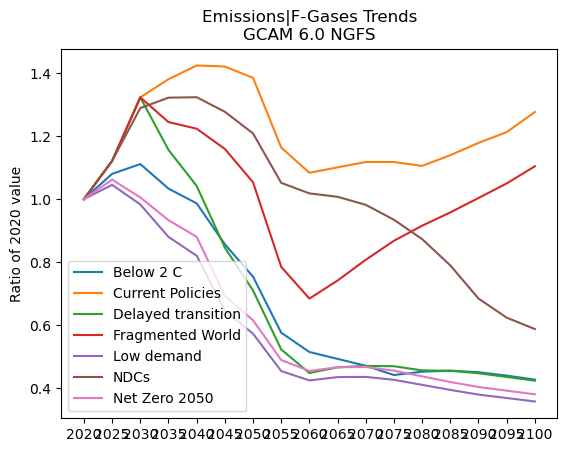

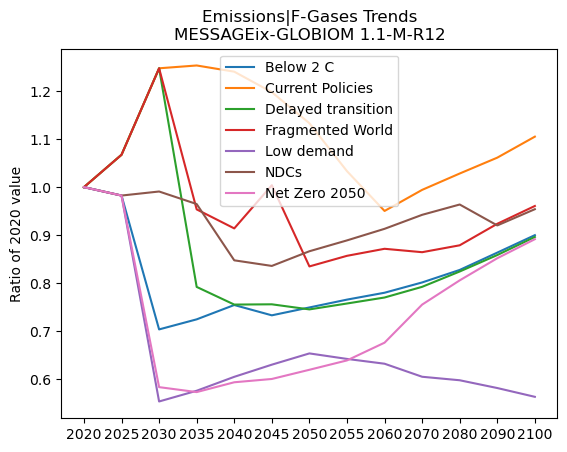

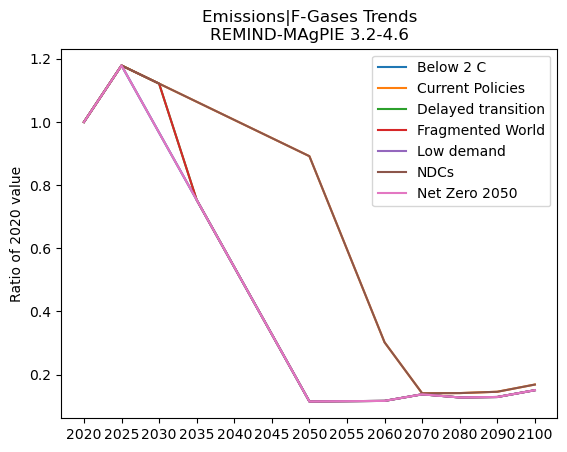

In [20]:
for df in [GCAM_f_perc, MSG_f_perc, REM_f_perc]:
    plot_trend(df, 'Emissions|F-Gases')

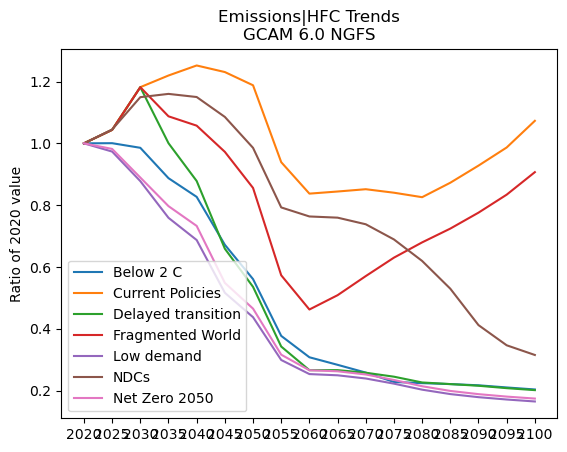

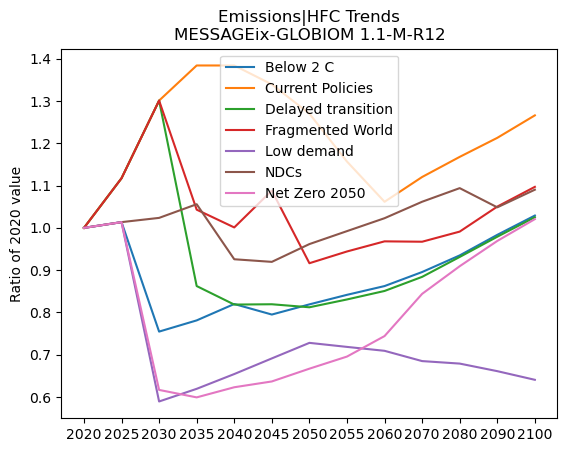

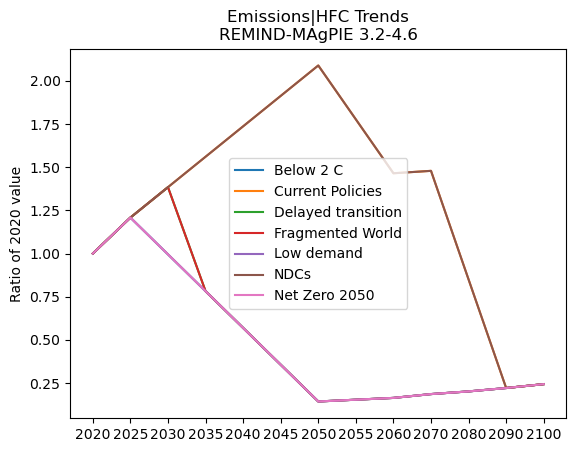

In [21]:
for df in [GCAM_f_perc, MSG_f_perc, REM_f_perc]:
    plot_trend(df, 'Emissions|HFC')

scale values relative to 2022 baseline

In [22]:
GCAM_missing

array(['Emissions|C3F8', 'Emissions|C4F10', 'Emissions|C5F12',
       'Emissions|C6F14', 'Emissions|C7F16', 'Emissions|C8F18',
       'Emissions|CCl4', 'Emissions|CFC-11', 'Emissions|CFC-113',
       'Emissions|CFC-114', 'Emissions|CFC-115', 'Emissions|CFC-12',
       'Emissions|CH2Cl2', 'Emissions|CH3Br', 'Emissions|CH3CCl3',
       'Emissions|CH3Cl', 'Emissions|CHCl3', 'Emissions|HCFC-141b',
       'Emissions|HCFC-142b', 'Emissions|HCFC-22', 'Emissions|HFC-152a',
       'Emissions|HFC-236fa', 'Emissions|HFC-365mfc',
       'Emissions|HFC-4310mee', 'Emissions|Halon-1211',
       'Emissions|Halon-1301', 'Emissions|Halon-2402', 'Emissions|NF3',
       'Emissions|SO2F2', 'Emissions|c-C4F8'], dtype=object)

In [23]:
curr_var = GCAM_missing[0]
scen = 'Net Zero 2050'

GCAM_infilled = GCAM_proj_2022.copy()
curr_df = GCAM_infilled

In [24]:
curr_row = curr_df.loc[curr_df.Variable==curr_var].loc[curr_df.Scenario == scen]
curr_row

,Model,Scenario,Region,Variable,Unit,2020,2025,2030,2035,2040,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
153,GCAM 6.0 NGFS,Net Zero 2050,World,Emissions|C3F8,kt C3F8/yr,0.380074,0.380074,0.380074,0.380074,0.380074,...,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074


In [25]:
perc_df = GCAM_f_perc
scaling_factors = perc_df.loc[perc_df.Variable=='Emissions|F-Gases'].loc[perc_df.Scenario==scen]
scaling_factors

,Model,Scenario,Region,Variable,Unit,2020,2025,2030,2035,2040,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
12,GCAM 6.0 NGFS,Net Zero 2050,World,Emissions|F-Gases,Ratio of 2020 value,1.0,1.061739,1.00539,0.933122,0.880349,...,0.489856,0.45504,0.467103,0.467651,0.456183,0.438035,0.420131,0.40432,0.392643,0.381207


In [26]:
factor = scaling_factors['2025'].values[0]
factor

1.0617389003404096

In [27]:
old = curr_row['2025'].values[0]
old

0.3800737993356019

In [28]:
new = old * factor
new

0.4035391377547835

In [29]:
curr_row['2025'] = new

In [30]:
curr_row

,Model,Scenario,Region,Variable,Unit,2020,2025,2030,2035,2040,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
153,GCAM 6.0 NGFS,Net Zero 2050,World,Emissions|C3F8,kt C3F8/yr,0.380074,0.403539,0.380074,0.380074,0.380074,...,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074


In [31]:
def scale_df(df_to_scale, perc_df, var):
    for scen in df_to_scale.Scenario.unique():
        
        mask = (df_to_scale['Variable'] == var) & (df_to_scale['Scenario'] == scen)
        scaling_factors = perc_df.loc[perc_df.Variable=='Emissions|F-Gases'].loc[perc_df.Scenario==scen]

        for yr in df_to_scale.columns[6:]:
            # calculate the new value based on the scaling factor for that yr
            factor = scaling_factors[yr].values[0]
            old = df_to_scale.loc[mask, yr].values[0]
            new = old * factor

            # set the scaled value for that year
            df_to_scale.loc[mask, yr] = new
            
    return df_to_scale

In [32]:
def infill(proj_2022, perc_df, missing_vars):
    infilled_df = proj_2022.copy()

    for var in missing_vars:
        infilled_df = scale_df(infilled_df, perc_df, var)
        
    return infilled_df

In [33]:
GCAM_infilled = infill(GCAM_proj_2022, GCAM_f_perc, GCAM_missing)
MSG_infilled = infill(MSG_proj_2022, MSG_f_perc, MSG_missing)
REM_infilled = infill(REM_proj_2022, REM_f_perc, REM_missing)

## Interpolate & saveprojections

Run interpolations & save as .csv

In [34]:
GCAM_interp_2022 = NGFS_interp(GCAM_proj_2022, GCAM_yrs, all_yrs)
MSG_interp_2022 = NGFS_interp(MSG_proj_2022, MSG_yrs, all_yrs)
REM_interp_2022 = NGFS_interp(REM_proj_2022, REM_yrs, all_yrs)

GCAM_interp_2022.to_csv('~/outputs/GCAM_interp_2022.csv', index=False)
MSG_interp_2022.to_csv('~/outputs/MSG_interp_2022.csv', index=False)
REM_interp_2022.to_csv('~/outputs/REM_interp_2022.csv', index=False)

In [35]:
GCAM_infilled = NGFS_interp(GCAM_infilled, GCAM_yrs, all_yrs)
MSG_infilled = NGFS_interp(MSG_infilled, MSG_yrs, all_yrs)
REM_infilled = NGFS_interp(REM_infilled, REM_yrs, all_yrs)

GCAM_infilled.to_csv('~/outputs/GCAM_infilled.csv', index=False)
MSG_infilled.to_csv('~/outputs/MSG_infilled.csv', index=False)
REM_infilled.to_csv('~/outputs/REM_infilled.csv', index=False)